# Train Boltzmann generators using generated samples

In [1]:
# Import modules
import torch
import numpy as np

import boltzgen as bg

from tqdm import tqdm

from matplotlib import pyplot as plt

In [2]:
# Specify checkpoint root
checkpoint_root = '/draco/u/vstimper/Material_Informatics/boltzmann_generators/models/rnvp_gen_init_01/'

In [3]:
# Load config
config = bg.utils.get_config(checkpoint_root + 'config/bm.yaml')

In [9]:
# Load data
training_data = bg.utils.load_traj('/draco/u/vstimper/Material_Informatics/boltzmann_generators/data/trajectory/aldp_without_const_100000.h5')

In [10]:
# Setup model
model = bg.BoltzmannGenerator(config)

# Move model on GPU if available
enable_cuda = False
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)
model = model.double()

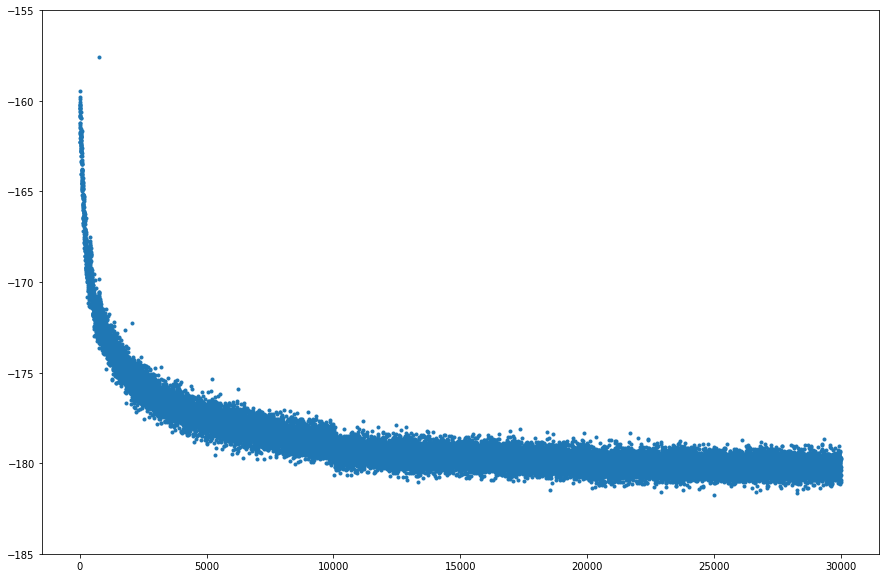

In [11]:
# Plot loss
loss = np.loadtxt(checkpoint_root + 'log/loss.csv')
plt.figure(figsize=(15, 10))
plt.plot(loss, '.')
plt.ylim(-185, -155)
plt.show()

In [7]:
# Load checkpoint
model.load(checkpoint_root + 'checkpoints/model_30000.pt')

In [12]:
# Initialize ActNorm layers
batch_size = 256
ind = torch.randint(len(training_data), (batch_size,))
x = training_data[ind, :].double().to(device)
kld = model.forward_kld(x)

In [ ]:
rkld_hist = np.array([])
alph1_hist = np.array([])
alph2_hist = np.array([])

for i in tqdm(range(0, 30000, 100)):
    model.load(checkpoint_root + 'checkpoints/model_%05i.pt' % (i + 100))
    
    rkld = model.reverse_kld(batch_size)
    alph1 = model.reverse_alpha_div(batch_size, alpha=1)
    alph2 = model.reverse_alpha_div(batch_size, alpha=2)
    
    rkld_hist = np.append(rkld_hist, rkld.to('cpu').data.numpy())
    alph1_hist = np.append(alph1_hist, alph1.to('cpu').data.numpy())
    alph2_hist = np.append(alph2_hist, alph2.to('cpu').data.numpy())

In [ ]:
plt.plot(rkld_hist - rkld_hist[0], '.')
plt.show()

plt.plot(alph1_hist)
plt.show()

plt.plot(alph2_hist)
plt.show()

In [13]:
# Train model
max_iter = 5000

n_data = len(training_data)
#"""
loss_hist = np.array([])
fkld_hist = np.array([])
rkld_hist = np.array([])
logq_hist = np.array([])
logp_hist = np.array([])
alph1_hist = np.array([])
alph2_hist = np.array([])
ang_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,
                             weight_decay=1e-5)
#"""

beta = np.concatenate([np.geomspace(1e-4, 1, 4000), np.ones(1000)])

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    ind = torch.randint(n_data, (batch_size, ))
    x = training_data[ind, :].double().to(device)
    fkld = model.forward_kld(x)
    #alph1 = model.reverse_alpha_div(batch_size, alpha=1)
    #alph2 = model.reverse_alpha_div(batch_size, alpha=2)
    #rkld = model.reverse_kld(batch_size)
    z, logq = model.sample(batch_size)
    logp = model.p.log_prob(z)
    rkld = torch.mean(logq) - torch.mean(logp) #-torch.logsumexp(1 * (logp - logq), 0)
    ang = torch.mean(model.flows[-1].mixed_transform.ic_transform.angle_loss)
    loss = rkld + ang
    if not torch.isnan(loss):
        #loss = loss / loss.detach()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 20)
        #torch.nn.utils.clip_grad_value_(model.parameters(), 0.01)
        optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    fkld_hist = np.append(fkld_hist, fkld.to('cpu').data.numpy())
    rkld_hist = np.append(rkld_hist, rkld.to('cpu').data.numpy())
    logq_hist = np.append(logq_hist, torch.mean(logq).to('cpu').data.numpy())
    logp_hist = np.append(logp_hist, torch.mean(logp).to('cpu').data.numpy())
    #alph1_hist = np.append(alph1_hist, alph1.to('cpu').data.numpy())
    #alph2_hist = np.append(alph2_hist, alph2.to('cpu').data.numpy())
    ang_hist = np.append(ang_hist, ang.to('cpu').data.numpy())

100%|██████████| 5000/5000 [14:38<00:00,  5.76it/s]


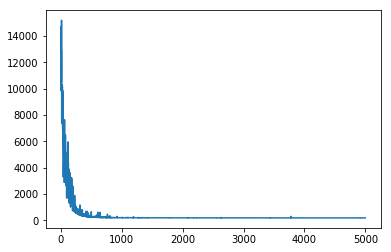

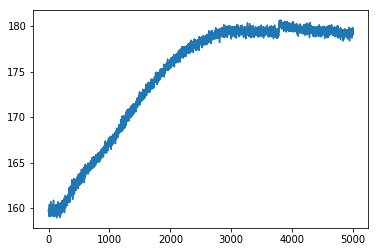

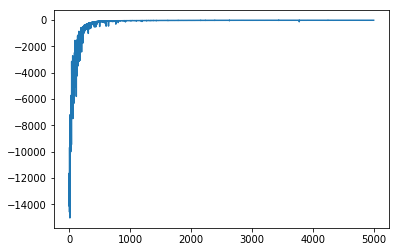

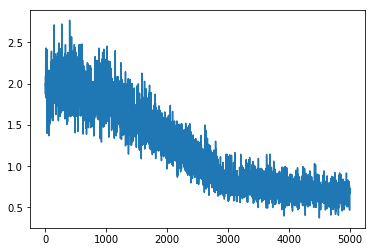

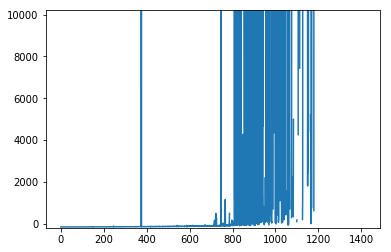

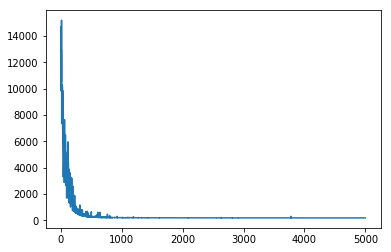

In [14]:
plt.plot(rkld_hist)
#plt.ylim(180, 300)
plt.show()

plt.plot(logq_hist)
plt.show()

plt.plot(logp_hist)
plt.show()

plt.plot(ang_hist)
plt.show()

plt.plot(fkld_hist)
plt.ylim(-200, 10200)
plt.show()

plt.plot(loss_hist)
plt.show()

In [16]:
# Draw samples

nth = 1

model.eval()

z_np = np.zeros((0, 60))
x_np = np.zeros((0, 66))
log_p_np = np.zeros((0,))
log_q_np = np.zeros((0,))

for i in tqdm(range(100 // nth)):
    z, log_q = model.sample(1000)
    x_np = np.concatenate((x_np, z.cpu().data.numpy()))
    log_p = model.p.log_prob(z)
    z, _ = model.flows[-1].inverse(z)
    z_np_ = z.cpu().data.numpy()
    log_p_np_ = log_p.cpu().data.numpy()
    log_q_np_ = log_q.cpu().data.numpy()
    z_np = np.concatenate((z_np, z_np_))
    log_p_np = np.concatenate((log_p_np, log_p_np_))
    log_q_np = np.concatenate((log_q_np, log_q_np_))


z_d = training_data[::nth].double().to(device)
log_p_d = model.p.log_prob(z_d)
z_d, _ = model.flows[-1].inverse(z_d)
z_d_np = z_d.cpu().data.numpy()

log_p_d_np = log_p_d.cpu().data.numpy()

100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


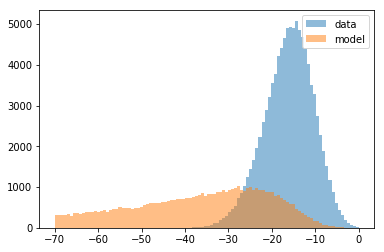

In [17]:
plt.hist(log_p_d_np, bins=100, alpha=0.5, label='data', range=[-70, 0])
plt.hist(log_p_np, bins=100, alpha=0.5, label='model', range=[-70, 0])
plt.legend(loc='upper right')
plt.show()

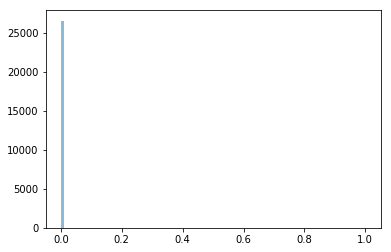

In [19]:
log_w = log_p_np - log_q_np
log_w = log_w[log_p_np < -50]
plt.hist(np.exp(log_w - np.max(log_w)), bins=100, alpha=0.5)
plt.show()

In [13]:
np.sort(log_p_d_np)

array([-44.91487773, -43.6572255 , -43.11482724, ...,  13.31867431,
        13.64416103,  13.87349588])

0


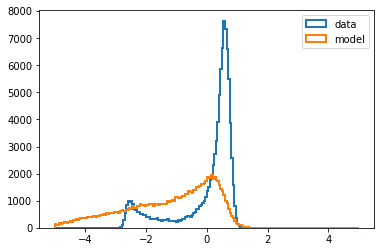

1


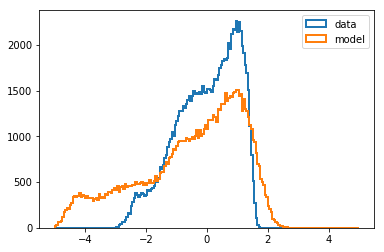

2


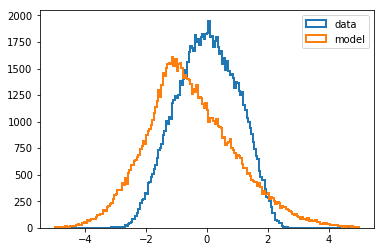

3


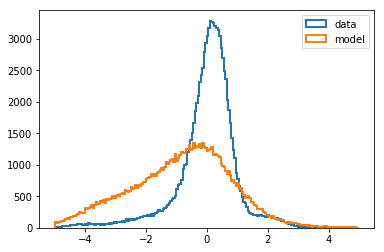

4


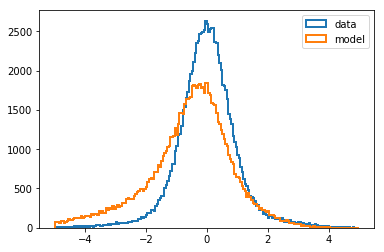

5


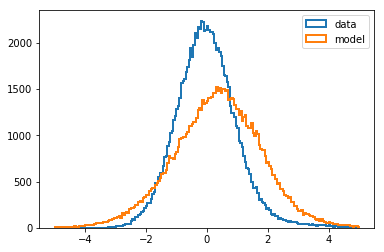

6


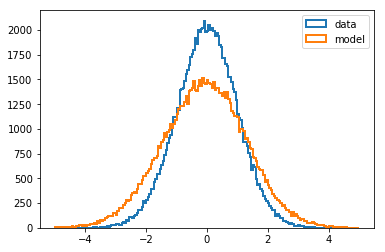

7


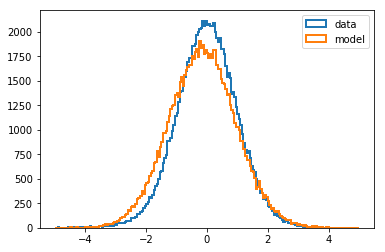

8


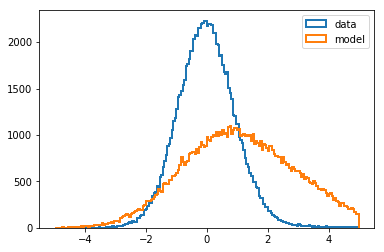

9


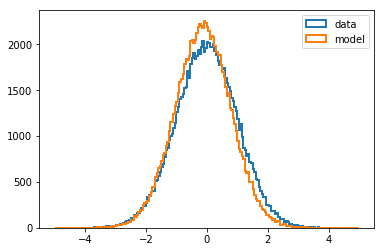

10


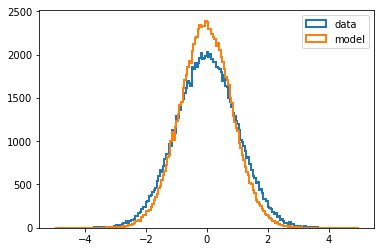

11


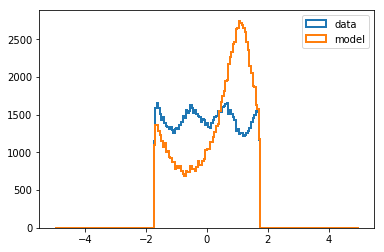

12


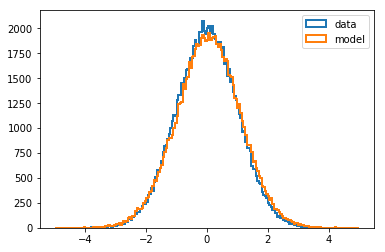

13


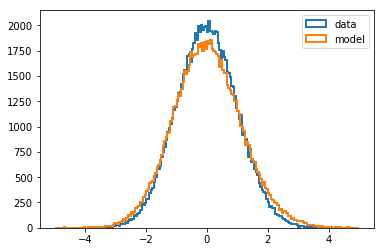

14


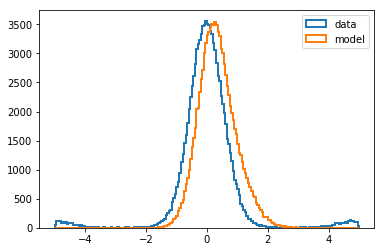

15


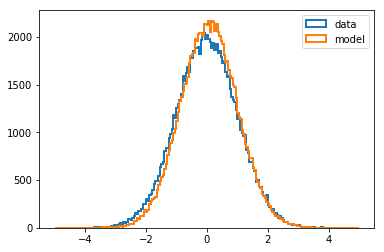

16


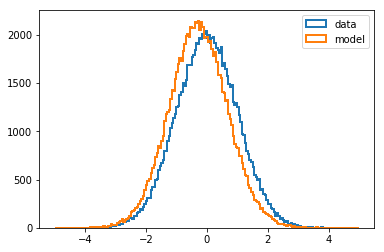

17


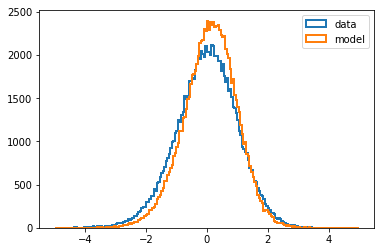

18


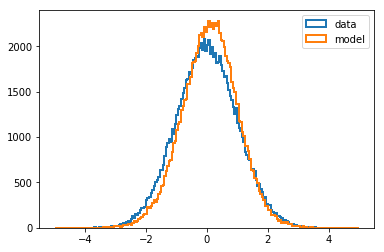

19


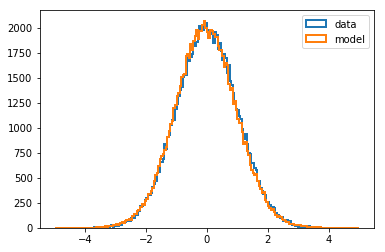

20


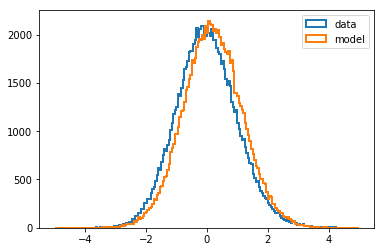

21


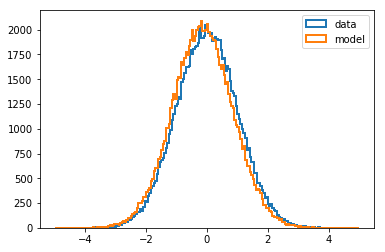

22


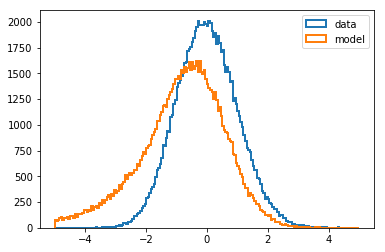

23


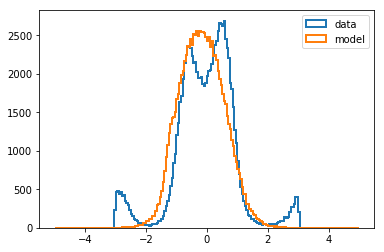

24


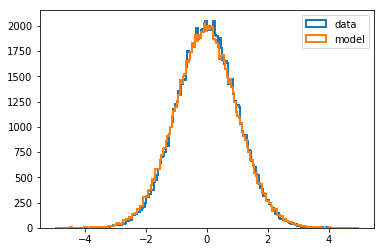

25


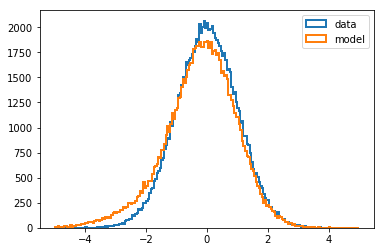

26


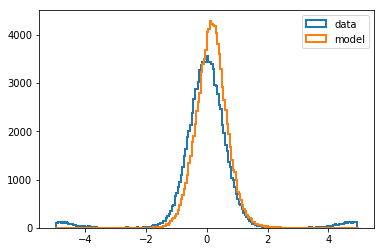

27


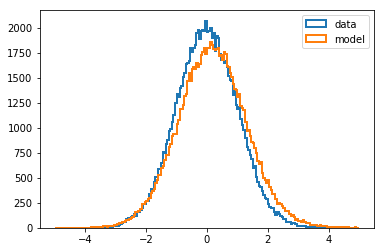

28


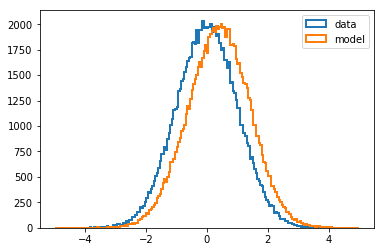

29


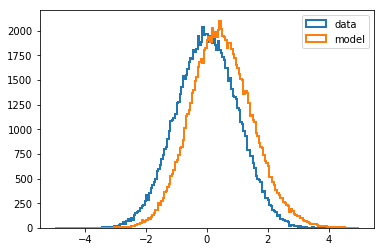

30


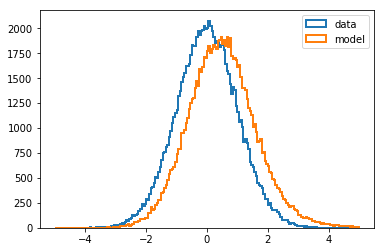

31


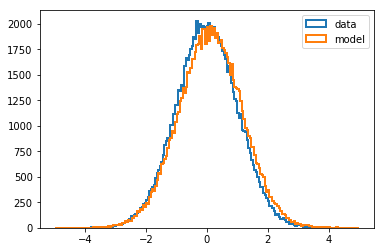

32


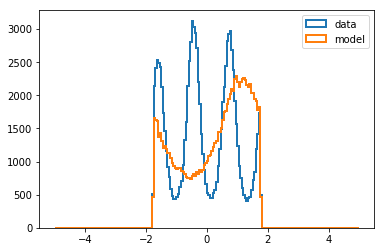

33


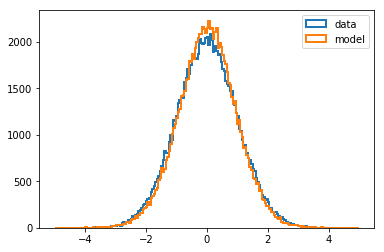

34


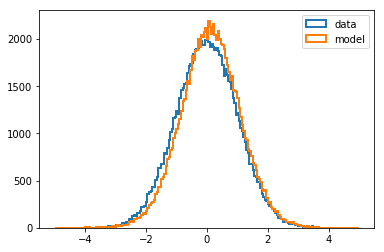

35


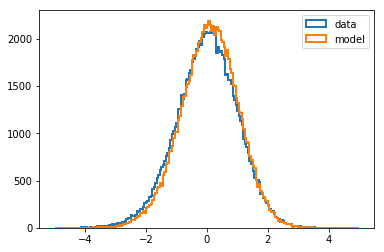

36


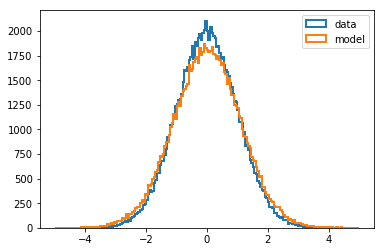

37


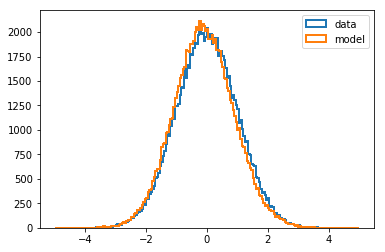

38


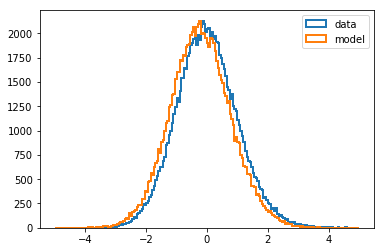

39


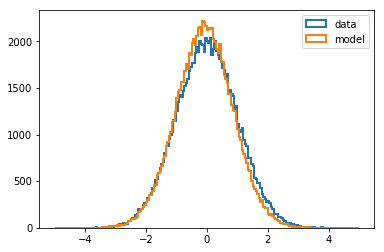

40


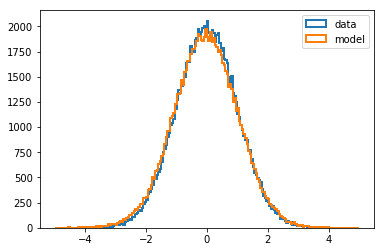

41


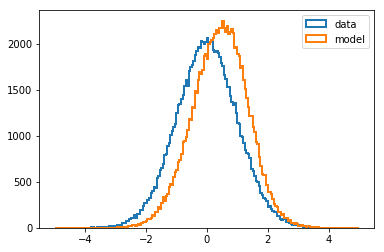

42


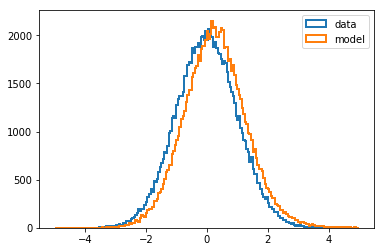

43


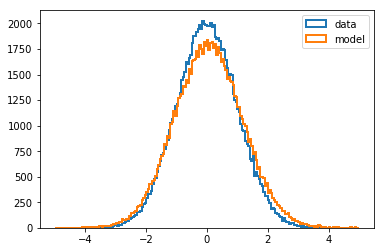

44


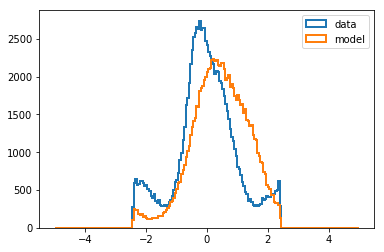

45


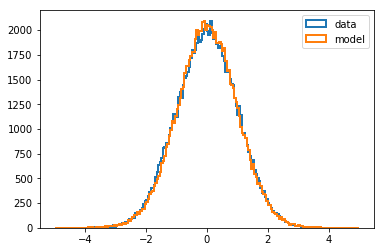

46


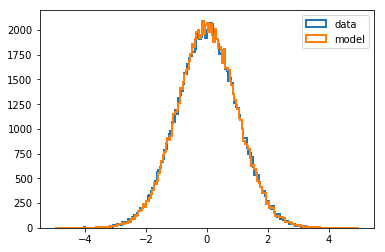

47


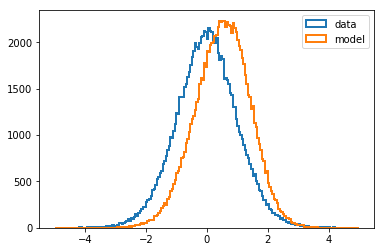

48


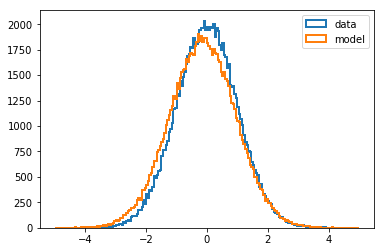

49


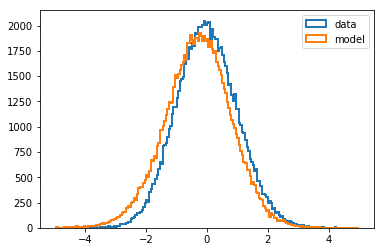

50


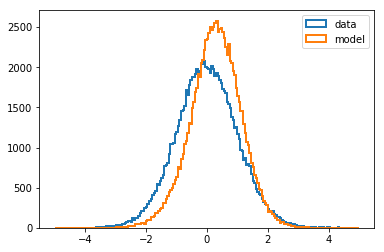

51


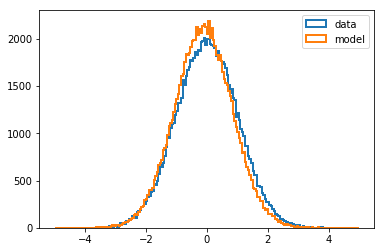

52


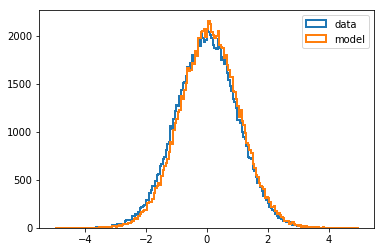

53


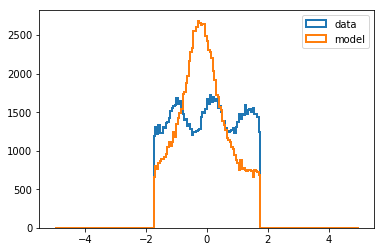

54


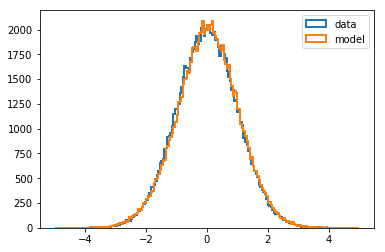

55


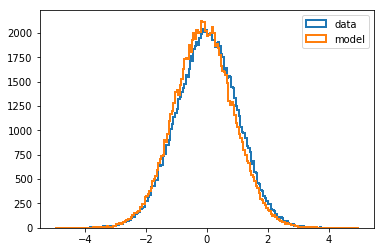

56


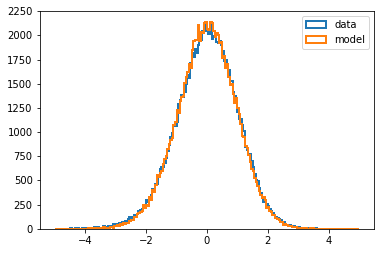

57


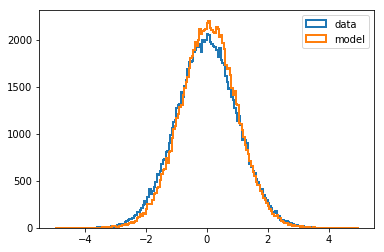

58


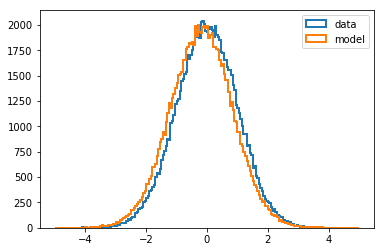

59


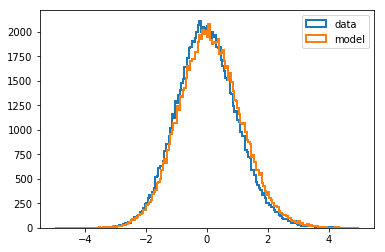

In [18]:
for i in range(60):
    print(i)
    plt.hist(z_d_np[:, i], bins=200, alpha=1, label='data', histtype='step', linewidth=2, range=[-5, 5])
    plt.hist(z_np[:, i], bins=200, alpha=1, label='model', histtype='step', linewidth=2, range=[-5, 5])
    plt.legend(loc='upper right')
    plt.show()